In [2]:
import numpy as np

In [3]:
import requests
import os

In [4]:
import cv2
from PIL import Image

In [5]:
os.chdir('Documents/Projects/ImageRec')

In [6]:
import matplotlib.pyplot as plt

In [7]:
def img_save(query_term, offset):
    '''
    saves and processes images for specified query, creates folder in directory if there isnt one
    '''
    
    API_KEY = os.getenv('bing_search_api_key')
    URL = "https://api.cognitive.microsoft.com/bing/v7.0/images/search"
    USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)' + \
                 'Chrome/80.0.3987.87 Safari/537.36'
    
    # set path with query term as file name
    path = os.getcwd().replace('\\', '/') + '/' + str(query_term) + '/'
    
    if not os.path.exists(query_term):
        # if the directory does not exist, make one
        os.mkdir(query_term)
        
    headers = {"Ocp-Apim-Subscription-Key" : API_KEY}
    params = {"q": query_term,
              "count": 150, 
              "offset": offset * 150}

    # Search Bing for images
    search = requests.get(URL, headers=headers, params=params)
    results = search.json()
    
    print('TOTAL ESTIMATED MATCHES: ' + str(results['totalEstimatedMatches']))

    # Save all of the resulting images from each page
    num = offset * 150
    for value in results['value']:

        print(str(num) + ' ' + value['contentUrl'], end='\r')
        
        try:
            image = requests.get(value["contentUrl"], timeout=30, headers={'User-Agent': USER_AGENT})
            
        except(requests.ConnectionError):
            print(str(num) + ' BAD CONNECTION', end='\r')
            continue
            
        except(requests.ReadTimeout):
            print(str(num) + ' TIMEOUT', end='\r')
            continue
        
        # Check the status of the request - If the image does not exist we will skip it
        try:
            image.raise_for_status()
            
            file = open(path + query_term + '_' + str(offset) + '_' + str(num) + '.png', 'wb')
            file.write(image.content)
            file.close()
            
        except(requests.HTTPError):
            print(str(num) + ' NOT FOUND', end='\r')
            
        num += 1

In [200]:
def img_format(folder):
    '''
    read in all images in given folder, format them, and put them into a master array
    return x_data array, y_data array
    '''
    
    x_data = np.array([])
    Y_data = np.array([])
    
    # Iterate through each file in the specified folder
    for file in os.listdir(folder):
        
        print(file, end='\r')
        
        # Read in the image
        img = np.array(Image.open(folder + '/' + file))
        
        # If the image is greyscale, discard it
        if len(img.shape) == 2:
            continue
        
        # If the image is 4 channel (RGBA), convert to 3 channel (RGB)
        if (len(img.shape) > 2) & (img.shape[2] == 4):
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        
        # Identify which sides need to be padded and by how much, to make the image square
        short = np.argmin(img.shape[:2])
        diff_1 = int(np.ceil(abs(img.shape[1] - img.shape[0])/2))
        diff_2 = int(np.floor(abs(img.shape[1] - img.shape[0])/2))
        
        # Set the desired padding on the short side, and apply
        width = [[0, 0], [0, 0], [0, 0]]
        width[short] = [diff_1, diff_2]
        img = np.pad(img, pad_width=width)
        
        # Resize square image to 100x100
        img = cv2.resize(img, (100, 100))
        
        # Reshape array to be appended to x_data array
        img = img.reshape(1, 100, 100, 3)
        
        # Put the formatted arrays into a master array of training data
        if np.array_equal(x_data, np.array([])):
            # This is the first one, start the array
            x_data = img
            
        else:
            # Append to full array
            x_data = np.concatenate((x_data, img), axis=0)
        
        # The class label will be same as the name of the folder
        Y_data = np.append(Y_data, folder)
    
    return x_data, Y_data

In [229]:
def img_predict(img, nn_model):
    '''
    reads in a single image, proccesses it, and generates predictions from the neural network
    assumes incoming image is square
    returns prediction array
    '''
    
    # Resize to 100x100
    img = cv2.resize(img, (100, 100))
    
    # Reshape to NN friendly shape
    img = img.reshape(1, 100, 100, 3)
    
    # Generate prediction array from given NN model
    pred = nn_model.predict(img.astype(float))
    
    return pred[0]

Save the images from search queries

Format the images and save to arrays

In [201]:
x_cat, Y_cat = img_format('cat')
x_dog, Y_dog = img_format('dog')
x_snake, Y_snake = img_format('snake')
x_penguin, Y_penguin = img_format('penguin')
x_dolphin, Y_dolphin = img_format('dolphin')

In [203]:
x_train = np.concatenate((x_cat, x_dog, x_snake, x_penguin, x_dolphin))

In [205]:
Y_train = np.concatenate((Y_cat, Y_dog, Y_snake, Y_penguin, Y_dolphin))

In [206]:
Y_train[Y_train == 'cat'] = 0
Y_train[Y_train == 'dog'] = 1
Y_train[Y_train == 'snake'] = 2
Y_train[Y_train == 'penguin'] = 3
Y_train[Y_train == 'dolphin'] = 4

In [207]:
Y_train = Y_train.astype(np.int)

Train NN

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [208]:
nn_model = Sequential()

In [209]:
nn_model.add(Dense(16, input_shape=x_train[0].shape, activation='relu'))
nn_model.add(Dense(16,  activation='relu'))
nn_model.add(Flatten())
nn_model.add(Dense(len(np.unique(Y_train)),  activation='softmax'))

In [210]:
nn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100, 100, 16)      64        
_________________________________________________________________
dense_12 (Dense)             (None, 100, 100, 16)      272       
_________________________________________________________________
flatten_4 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 800005    
Total params: 800,341
Trainable params: 800,341
Non-trainable params: 0
_________________________________________________________________


In [211]:
nn_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

nn_model.fit(x=x_train, y=Y_train, epochs=10)

Train on 2433 samples
Epoch 1/10
2433/2433 [==============================] - 9s 4ms/sample - loss: 977.1000 - accuracy: 0.3933
Epoch 2/10
2433/2433 [==============================] - 8s 3ms/sample - loss: 186.0002 - accuracy: 0.5495
Epoch 3/10
2433/2433 [==============================] - 8s 3ms/sample - loss: 96.4075 - accuracy: 0.6025
Epoch 4/10
2433/2433 [==============================] - 8s 3ms/sample - loss: 66.8018 - accuracy: 0.6436
Epoch 5/10
2433/2433 [==============================] - 8s 3ms/sample - loss: 16.9471 - accuracy: 0.7341
Epoch 6/10
2433/2433 [==============================] - 8s 3ms/sample - loss: 20.3812 - accuracy: 0.7222
Epoch 7/10
2433/2433 [==============================] - 8s 3ms/sample - loss: 3.7469 - accuracy: 0.8413
Epoch 8/10
2433/2433 [==============================] - 8s 3ms/sample - loss: 2.9036 - accuracy: 0.85490s - loss: 2.9381 - 
Epoch 9/10
2433/2433 [==============================] - 8s 3ms/sample - loss: 2.1742 - accuracy: 0.8755
Epoch 10/10
24

In [ ]:
# cat
# dog
# snake
# penguin
# dolphin
# dog & cat
# cat over ocean
# dog dressed as penguin
# cartoon penguin
# catdog

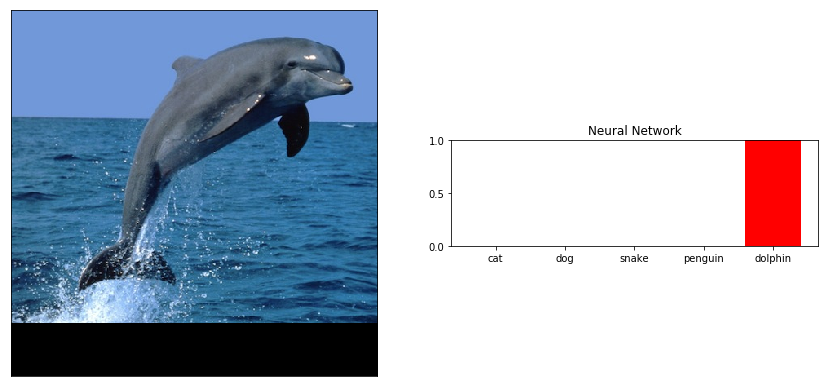

In [232]:
nn_pred = img_predict(img, nn_model)
labels = ['cat', 'dog', 'snake', 'penguin', 'dolphin']

# Plot Image
fig = plt.figure()

plt.subplot2grid((3, 2), (0 ,0), rowspan=3)
plt.imshow(img, cmap='Greys')
plt.xticks([])
plt.yticks([])

# Plot CNN Prediction
plt.subplot2grid((3,2), (1, 1))
plt.bar(list(range(len(nn_pred))), nn_pred, color='red')
plt.xticks(np.arange(len(nn_pred)), labels)
plt.ylim([0, 1])
plt.title('Neural Network')
plt.yticks([0, .5, 1])

fig.tight_layout()
fig.set_size_inches(w=12,h=6)

In [225]:
# Resize to 100x100
img100 = cv2.resize(img, (100, 100))

# Reshape to NN friendly shape
imgre = img100.reshape(1, 100, 100, 3)

In [230]:
img_predict(img, nn_model)

array([0., 0., 0., 0., 1.], dtype=float32)